<a href="https://colab.research.google.com/github/chen-star/llm_model_trainings/blob/main/7_1_evaluation_quantitative_perplexity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> ⭐ Evaluation ⭐

---

* **Token Level**

  - logits-based
  - syntax
  - grammar
  - ngram
  - statistics


* **Sentence Level**

  - accuracy-based
  - grammar
  - world knowledge


* **Discourse Level**

  - distribution-based
  - style
  - human-like

---

# ✈ Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests

import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, GPT2Tokenizer
from datasets import load_dataset

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# 🔢 Hyperparameters

In [2]:
# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
context_window_size = 1024

# 🐶 Perplexity

To masure how well the model predicts tokens, and how well it separates target from non-target tokens.

```
P = exp( 1/N * sum(L(i) for i in range(N)) )
    N: # of tokens
    L: Loss func

P is the exponential of averaged total loss.
```

In [4]:
# perplexity func
def perplexity(model, tokens, context_window_size=1024):
  n = torch.numel(tokens) // context_window_size

  total_loss = 0

  for i in range(n):
    start = i * context_window_size
    end = start + context_window_size

    X = tokens[0, start:end].unsqueeze(0)

    # forward pass
    with torch.no_grad():
      logits = model(X, labels=X)

    total_loss += logits.loss.item()

  perplexity = torch.exp(torch.tensor(total_loss) / n)
  return perplexity

In [5]:
text = load_dataset('wikitext','wikitext-2-raw-v1',split='test')

README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

#### Compare perplexity of different GPT-2 models

In [6]:
model_ids = ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl', ]

models = {}
for id in model_ids:
  models[id] = AutoModelForCausalLM.from_pretrained(id).to(device)
  models[id].eval()

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [7]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokens = tokenizer.encode('\n'.join(text['text'][:2000]),return_tensors='pt').to(device)
torch.numel(tokens)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (136702 > 1024). Running this sequence through the model will result in indexing errors


136702

In [8]:
# calc perplexity for each GPT-2 model

perplexities = {}
for id in model_ids:
  print(f"Calculating perplexity for {id}...")
  perplexities[id] = perplexity(models[id], tokens, context_window_size)
  print(f"Perplexity for {id}: {perplexities[id]:.2f}")

Calculating perplexity for gpt2...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Perplexity for gpt2: 29.77
Calculating perplexity for gpt2-medium...
Perplexity for gpt2-medium: 21.40
Calculating perplexity for gpt2-large...
Perplexity for gpt2-large: 18.70
Calculating perplexity for gpt2-xl...
Perplexity for gpt2-xl: 16.91


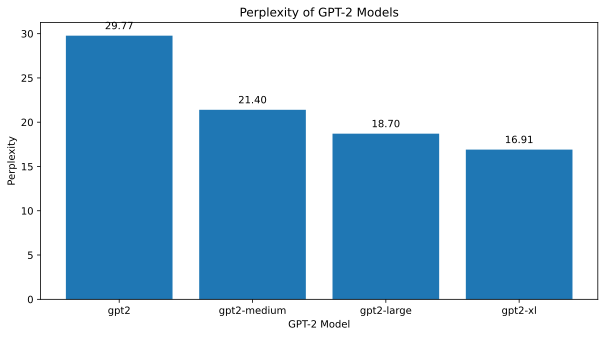

In [9]:
# plot the perplexity for each GPT-2 model

plt.figure(figsize=(10,5))
plt.bar(perplexities.keys(), perplexities.values())
plt.title('Perplexity of GPT-2 Models')
plt.xlabel('GPT-2 Model')
plt.ylabel('Perplexity')

for i, (model_id, perplexity_val) in enumerate(perplexities.items()):
    plt.text(i, perplexity_val + 0.5, f'{perplexity_val:.2f}', ha='center', va='bottom')

plt.show()

#### Compare perplexity of different context window size

In [10]:
context_window_sizes = 2**np.arange(6,11) # Limiting to 1024, as gpt2 has a max context of 1024

In [11]:
# calc perplexity for each context window size

perplexity_by_window_size = {}
model_to_use = models['gpt2'] # Using 'gpt2' as the reference model

for window_size in context_window_sizes:
  print(f"Calculating perplexity for context window size: {window_size}...")
  perplexity_by_window_size[window_size] = perplexity(model_to_use, tokens, window_size)
  print(f"Perplexity for window size {window_size}: {perplexity_by_window_size[window_size]:.2f}")

Calculating perplexity for context window size: 64...
Perplexity for window size 64: 89.49
Calculating perplexity for context window size: 128...
Perplexity for window size 128: 60.55
Calculating perplexity for context window size: 256...
Perplexity for window size 256: 44.91
Calculating perplexity for context window size: 512...
Perplexity for window size 512: 35.52
Calculating perplexity for context window size: 1024...
Perplexity for window size 1024: 29.77


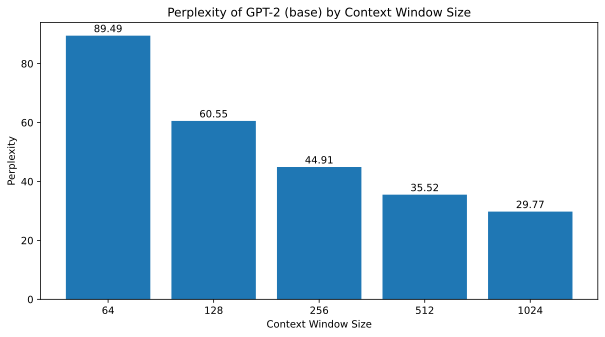

In [12]:
# plot perplexity for each context window size

plt.figure(figsize=(10,5))
plt.bar([str(s) for s in perplexity_by_window_size.keys()], perplexity_by_window_size.values())
plt.title('Perplexity of GPT-2 (base) by Context Window Size')
plt.xlabel('Context Window Size')
plt.ylabel('Perplexity')

# Add perplexity values on top of each bar
for i, (window_size, perplexity_val) in enumerate(perplexity_by_window_size.items()):
    plt.text(i, perplexity_val + 0.5, f'{perplexity_val:.2f}', ha='center', va='bottom')

plt.show()